In [12]:
%matplotlib ipympl
import numpy as np
import pandas as pd
from numba import jit, vectorize, float64, types, int64
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

In [4]:
# Coupling formula
mu_0 = 12.5663706127e-7
h = 6.62607015e-34
alpha_w = mu_0/4/np.pi * (1.1282407e7)**2 *(h/2/np.pi)**2
gamma_ratio = 1.1282407/6.567400

a = 5.26e-10 # In meters
c = 11.35e-10 # In meters
# Lattive parameters:
lattice_x = np.array([a, 0, 0])
lattice_y = np.array([0, a, 0])
lattice_z = np.array([0, 0, c])

lattice_s = np.array([[a, a, c]]) * np.array([
    [0.5,0.5,0],
    [0,0.5,0.25],
    [0,0,0.5],
    [0.5,0,0.75],
])

site_nb = lattice_s.shape[0]

@vectorize([float64(int64, int64, int64, int64, int64)])
def compute_coupling(x, y, z, a, b):
    vec = x*lattice_x + y*lattice_y + z*lattice_z + lattice_s[a] - lattice_s[b]
    norm = np.linalg.norm(vec)
    return alpha_w/norm**3*(1-3*vec[2]**2/norm**2)/h

# State generation

In [5]:
def generate_lattice_sites(n, cell_number = 5):
    # TODO: Improve using random picking
    r = np.unique(np.random.randint([[cell_number, cell_number, cell_number, len(lattice_s)]], size=(n, 4)), axis = 0)
    np.random.shuffle(r)
    return r

def add_noise(couplings, sigma):
    return np.max(0, couplings + np.random.normal(scale = sigma, size = couplings.shape))

@jit
def couplings(sites):
    n = sites.shape[0]
    couplings = np.full((n , n), np.nan)
    for i in range(sites.shape[0]-1):
        for j in range(i+1, sites.shape[0]):
            x = sites[i][0] - sites[j][0]
            y = sites[i][1] - sites[j][1]
            z = sites[i][2] - sites[j][2]
            couplings[i, j] = compute_coupling(x, y, z, sites[i][3], sites[j][3])
    return couplings

In [6]:
test_sites = generate_lattice_sites(1000, cell_number=2)

In [7]:
test_couplings = couplings(test_sites)

In [20]:
cell_sites = np.unique(np.array([
    [0,0,0,0],
    [0,0,0,1],
    [0,0,0,2],
    [0,0,0,3],
    [0,0,1,0],
    [1,0,0,1],
    [0,1,0,3],
    [1,0,0,2],
    [0,1,0,2],
    [1,1,0,2],
    
    [1,0,0,0],
    [1,0,0,1],
    [1,0,0,2],
    [1,0,0,3],
    [1,0,1,0],
    [2,0,0,1],
    [1,1,0,3],
    [2,0,0,2],
    [1,1,0,2],
    [2,1,0,2],
]), axis=0)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,NaN,-2.264073,-0.751332,-0.525211,-0.292242,-0.751332,-0.525211,1.468056,-2.264073,-0.751332,-0.198837,-0.160386,-0.751332,-0.198837,0.237915,0.009824,0.009824
1,NaN,NaN,-2.264073,-0.751332,-0.525211,-2.264073,-0.751332,0.237915,1.468056,0.332662,0.009824,-0.083855,0.332662,0.009824,0.183507,0.122544,0.122544
2,NaN,NaN,NaN,-2.264073,-0.751332,1.468056,0.332662,0.009824,0.332662,1.468056,0.237915,0.009824,0.519036,0.166001,0.122544,0.183507,0.131307
3,NaN,NaN,NaN,NaN,-2.264073,0.332662,1.468056,-0.198837,-0.751332,-2.264073,1.468056,0.332662,0.332662,0.519036,0.009824,0.237915,0.166001
4,NaN,NaN,NaN,NaN,NaN,-0.751332,-2.264073,-0.160386,-0.525211,-0.751332,0.332662,1.468056,-0.751332,0.332662,-0.083855,0.009824,0.009824
5,NaN,NaN,NaN,NaN,NaN,NaN,-2.264073,0.009824,0.332662,0.519036,0.166001,0.009824,1.468056,0.237915,0.122544,0.131307,0.183507
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.198837,-0.751332,0.332662,0.519036,0.332662,-2.264073,1.468056,0.009824,0.166001,0.237915
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.264073,-0.751332,-0.525211,-0.292242,-0.751332,-0.525211,-2.264073,-0.751332,-0.751332
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.264073,-0.751332,-0.525211,-2.264073,-0.751332,1.468056,0.332662,0.332662
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.264073,-0.751332,1.468056,0.332662,0.332662,1.468056,0.519036


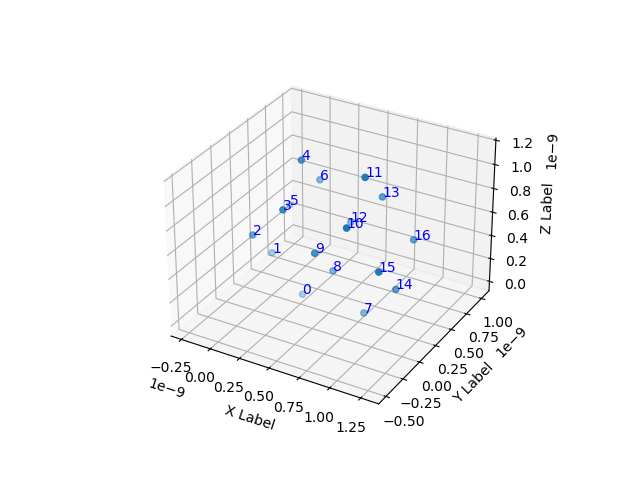

In [21]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')


positions = lattice_x[None,:]*cell_sites[:,0][:,None] + lattice_y[None,:] * cell_sites[:,1][:,None] + lattice_z[None,:] * cell_sites[:,2][:,None] + lattice_s[cell_sites[:,3]]

ax.scatter(positions[:,0], positions[:,1], positions[:,2])

for i in range(cell_sites.shape[0]):
    ax.text(positions[i,0], positions[i,1], positions[i,2], str(i), color="blue")
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.axis('equal')

pd.DataFrame(couplings(cell_sites))

# State reconstruction

In [6]:
@jit
def index_to_coord(index, max_distance, site_nb):
    center = max_distance // 2
    return (
        index // (max_distance**2 * site_nb**2) - center,
        index // (max_distance * site_nb**2) % max_distance - center,
        index // site_nb**2 % max_distance - center,
        index // site_nb % site_nb,
        index % site_nb
    )  

@jit
def coord_to_index(vec, max_distance, site_nb):
    center = max_distance // 2
    return site_nb**2 * ((vec[0] + center)*max_distance**2 + (vec[1] + center) * max_distance + (vec[2] + center)) + vec[3]*site_nb + vec[4]

#@jit #(locals={'current_set': types.Set(types.UniTuple(float64, 3))})
def vector_couplings(max_distance, site_nb, tolerance):
    print("Computing vector -> couplings lookup")
    couplings = np.empty(max_distance**3*site_nb**2)
    for i in range(max_distance**3*site_nb**2):
        couplings[i] = compute_coupling(
                    *index_to_coord(i, max_distance, site_nb)
                )
    # Revert the map
    print("Reverting the map")
    coupling_values = [] # OK to append to that list because O(number_spins)
    current_set = set(((0,0,0,0,0),))
    current_set.pop() # HACK for type inference
    vectors = [] # OK to append because O(number_spins)
    sorted_couplings = np.argsort(couplings)
    # i_max = coupling index st coupling + tolerance < current cursor
    # i_min = coupling index st coupling - tolerance < current cursor
    i_min, i_max = 0,0
    while not np.isnan(couplings[sorted_couplings[i_max]]):
        if np.isnan(couplings[sorted_couplings[i_min]]) or couplings[sorted_couplings[i_min]] - tolerance > couplings[sorted_couplings[i_max]] + tolerance:
            # Depile du côté des maxima (ie on retire un vecteur au set)
            vec = index_to_coord(sorted_couplings[i_max], max_distance, site_nb)
            coupling_cursor = couplings[sorted_couplings[i_max]] + tolerance
            if len(coupling_values) == 0 or not np.isclose(coupling_values[-1], coupling_cursor, rtol = 1e-9, atol = tolerance * 1e-9):
                vectors.append(current_set.copy())
                coupling_values.append(coupling_cursor)
            current_set.remove(vec)
            i_max += 1
        else:
            # Empile du côté des minima (ie on ajoute un vecteur au set)
            vec = index_to_coord(sorted_couplings[i_min], max_distance, site_nb)
            coupling_cursor = couplings[sorted_couplings[i_min]] - tolerance
            if len(coupling_values) == 0 or not np.isclose(coupling_values[-1], coupling_cursor, rtol = 1e-9, atol = tolerance * 1e-9):
                vectors.append(current_set.copy())
                coupling_values.append(coupling_cursor)
            current_set.add(vec)
            i_min += 1
    vectors.append(current_set)
    print("Successfully reverted the map")
    return np.array(coupling_values), vectors

In [7]:
@jit
def cost_function(sites, couplings):
    couplings_theory = couplings(sites)
    cost = 0
    for i in range(sites.shape[0]-1):
        for j in range(i+1, sites.shape[0]):
            if np.isnan(couplings[i,j]):
                continue
            x = sites[i][0] - sites[j][0]
            y = sites[i][1] - sites[j][1]
            z = sites[i][2] - sites[j][2]
            cost += (couplings[i,j] - compute_coupling(x, y, z, sites[i][3], sites[j][3]))**2
    return cost

@jit
def exchange_columns(couplings, permutation, a, b):
    a, b = min(a, b), max(a, b)
    print(f"Exchange {a}-{b}")
    permutation[a], permutation[b] = permutation[b], permutation[a]
    for i in range(a):
        couplings[i, a], couplings[i, b] = couplings[i, b], couplings[i, a]
    for i in range(a+1, b):
        couplings[a, i], couplings[i, b] = couplings[i, b], couplings[a, i]
    for i in range(b+1, couplings.shape[0]): 
        couplings[a, i], couplings[b, i] = couplings[b, i], couplings[a, i]

@jit
def set_placing_order(couplings):
    print(couplings.shape)
    n_tot = couplings.shape[0]
    permutation = np.arange(n_tot)
    m = np.nanmax(couplings[0,:])
    first = 0
    for i in range(1, n_tot):
        if np.nanmax(couplings[i,:])> m:
            m = np.nanmax(couplings[i,:])
            first = i
    exchange_columns(couplings, permutation, 0, first)
    for i in range(1, n_tot):
        next_index = np.argmax(couplings[:i,i:])%(n_tot-i) + i
        if next_index != i:
            exchange_columns(couplings, permutation, i, next_index)
    return couplings, permutation

#@jit
def compute_sites(couplings, lattice_size, site_nb, tolerance):
    print("Begin")
    n_placed = 1
    n_tot = couplings.shape[0]
    couplings, permutation = set_placing_order(couplings)
    print("ordered spins")
    couplings_vectors_tup = vector_couplings(tolerance = tolerance, max_distance = lattice_size*2, site_nb = site_nb)
    print("computed_lookup table")
    possible_configurations = []
    for i in range(site_nb):
        c = np.zeros((n_tot, 4), dtype = np.int64)
        c[0][3] = i
        possible_configurations.append(c)
        
    current_couplings = np.empty(n_tot) # stores current coupling values to other spins

    print("Initialization successful")
    while n_placed < n_tot:
        # First place them in order
        n_to_place = n_placed

        for i in range(n_tot):
            current_couplings[i] = couplings[n_to_place, i] if np.isnan(couplings[i, n_to_place]) else couplings[i, n_to_place]
        # Be careful, position relative to n_to_place-1
        candidates = couplings_vectors_tup[1][np.searchsorted(couplings_vectors_tup[0], current_couplings[n_to_place-1])]
        new_possible_configurations = []
        print(f"Placing {n_placed}. {len(candidates)} for each one of the {len(possible_configurations)} cases to process.")

        
        # TODO : switch code below to separate function using numba
        for config in tqdm(possible_configurations):
            for candidate in candidates:
                good_candidate = True
                # First check the origin lattice site
                if candidate[4] != config[n_to_place - 1][3]:
                    continue
                for i in range(n_placed-1):
                    if np.isnan(current_couplings[i]):
                        # no data for this already placed spin
                        continue
                    x = candidate[0] + config[n_to_place-1][0] - config[i][0]
                    y = candidate[1] + config[n_to_place-1][1] - config[i][1]
                    z = candidate[2] + config[n_to_place-1][2] - config[i][2]
                    a = candidate[3]
                    b = config[i][3]
                    if (x, y, z) == (0,0,0) and a == b:
                        good_candidate = False
                        break
                    coupling_candidate = compute_coupling(
                        x, y, z, a, b
                    )
                    if np.isnan(coupling_candidate) or np.abs(current_couplings[i] - coupling_candidate) > tolerance:
                        good_candidate = False
                        break
                if good_candidate:
                    new_config = config.copy()
                    new_config[n_to_place] = np.array((candidate[0] + config[n_to_place-1][0], candidate[1] + config[n_to_place-1][1], candidate[2] + config[n_to_place-1][2], candidate[3]))
                    new_possible_configurations.append(new_config)
        possible_configurations = new_possible_configurations
        n_placed+=1
    return possible_configurations, permutation



In [8]:
def check_configuration(sites, original):
    """
    Check if configurations are the same up to a translation
    """
    x_sites = np.min(sites[:,0])
    x_original = np.min(original[:,0])
    y_sites = np.min(sites[:,1])
    y_original = np.min(original[:,1])
    z_sites = np.min(sites[:,2])
    z_original = np.min(original[:,2])

    # useless allocation here we could do it in place...
    sites = sites + np.array([[x_original - x_sites, y_original - y_sites, z_original - z_sites, 0]])
    sites = np.sort(sites, axis=0)
    original = np.sort(original, axis=0)
    return np.array_equal(sites, original)

    
    

###  Load data

In [41]:
raw_data = np.genfromtxt("spin_couplings.csv", delimiter=",", filling_values = np.nan)[1:,1:]

renormalized_data = np.empty(raw_data.shape)


renormalized_data[0] = gamma_ratio * raw_data[0]

for i in range(1,renormalized_data.shape[0]):
    renormalized_data[i] = raw_data[i]*4


pd.DataFrame(renormalized_data)

,0,1,2,3,4,5,6,7,8
0,NaN,-1.1012,0.151179,0.041231,-0.163204,0.383101,0.383101,-0.104794,0.766202
1,NaN,NaN,5.412000,1.732000,-8.948000,0.000000,2.380000,0.000000,0.000000
2,NaN,NaN,NaN,0.000000,1.972000,-1.612000,-5.868000,0.000000,0.000000
3,NaN,NaN,NaN,NaN,-0.600000,0.000000,-0.308000,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:

pd.DataFrame(couplings(cell_sites))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,NaN,-2.264073,-0.751332,-0.525211,-0.292242,-0.751332,-0.525211,1.468056,-2.264073,-0.751332,-0.198837,-0.160386,-0.751332,-0.198837,0.237915,0.009824,0.009824
1,NaN,NaN,-2.264073,-0.751332,-0.525211,-2.264073,-0.751332,0.237915,1.468056,0.332662,0.009824,-0.083855,0.332662,0.009824,0.183507,0.122544,0.122544
2,NaN,NaN,NaN,-2.264073,-0.751332,1.468056,0.332662,0.009824,0.332662,1.468056,0.237915,0.009824,0.519036,0.166001,0.122544,0.183507,0.131307
3,NaN,NaN,NaN,NaN,-2.264073,0.332662,1.468056,-0.198837,-0.751332,-2.264073,1.468056,0.332662,0.332662,0.519036,0.009824,0.237915,0.166001
4,NaN,NaN,NaN,NaN,NaN,-0.751332,-2.264073,-0.160386,-0.525211,-0.751332,0.332662,1.468056,-0.751332,0.332662,-0.083855,0.009824,0.009824
5,NaN,NaN,NaN,NaN,NaN,NaN,-2.264073,0.009824,0.332662,0.519036,0.166001,0.009824,1.468056,0.237915,0.122544,0.131307,0.183507
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.198837,-0.751332,0.332662,0.519036,0.332662,-2.264073,1.468056,0.009824,0.166001,0.237915
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.264073,-0.751332,-0.525211,-0.292242,-0.751332,-0.525211,-2.264073,-0.751332,-0.751332
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.264073,-0.751332,-0.525211,-2.264073,-0.751332,1.468056,0.332662,0.332662
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.264073,-0.751332,1.468056,0.332662,0.332662,1.468056,0.519036


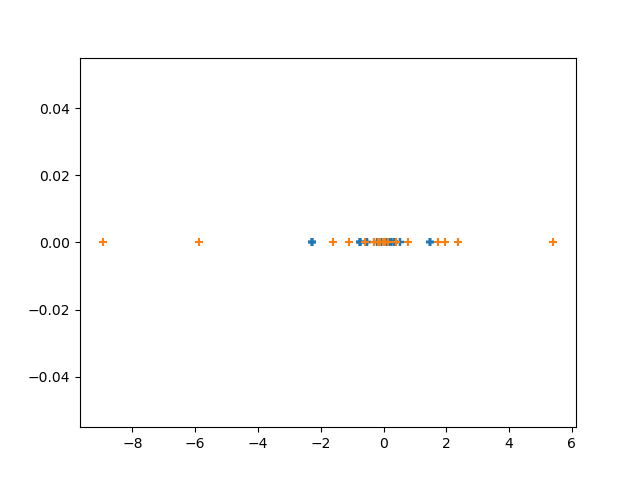

In [47]:
fig, ax = plt.subplots()
c = couplings(cell_sites)

data = c[~np.isnan(c)]

ax.scatter(data, np.zeros(data.shape), marker = "+")

c = renormalized_data[:,:]

data = c[~np.isnan(c)]
ax.scatter(data, np.zeros(data.shape), marker = "+")

### Compute

In [11]:
import time

t0 = time.perf_counter()
final_sites, permutation = compute_sites(renormalized_data, lattice_size = 10, site_nb=site_nb, tolerance = 5)
t = time.perf_counter() - t0
print(f"Time {t}")


Begin
(9, 9)
Exchange 0-0
ordered spins
Computing vector -> couplings lookup
Reverting the map
Successfully reverted the map
computed_lookup table
Initialization successful
Placing 1. 0 for each one of the 4 cases to process.


  0%|          | 0/4 [00:00<?, ?it/s]

Placing 2. 0 for each one of the 0 cases to process.


0it [00:00, ?it/s]

Placing 3. 0 for each one of the 0 cases to process.


0it [00:00, ?it/s]

Placing 4. 0 for each one of the 0 cases to process.


0it [00:00, ?it/s]

Placing 5. 0 for each one of the 0 cases to process.


0it [00:00, ?it/s]

Placing 6. 0 for each one of the 0 cases to process.


0it [00:00, ?it/s]

Placing 7. 0 for each one of the 0 cases to process.


0it [00:00, ?it/s]

Placing 8. 0 for each one of the 0 cases to process.


0it [00:00, ?it/s]

Time 5.114946451998549


In [59]:
f = -1
print(test_sites)
for i, s in enumerate(final_sites):
    if check_configuration(s, test_sites):
        print(f"OK {i}")
        f = i


[[0 0 1 0]
 [0 0 1 3]
 [0 1 1 3]
 [0 0 1 2]
 [0 0 0 0]
 [0 1 0 3]
 [1 1 1 3]
 [1 1 0 2]
 [1 0 1 3]
 [1 0 1 0]
 [1 1 0 0]
 [1 1 0 3]
 [1 1 1 2]
 [1 0 0 3]
 [0 1 1 1]
 [1 1 1 0]
 [1 0 0 2]
 [0 1 0 1]
 [1 1 1 1]
 [1 0 1 2]
 [0 1 0 0]
 [0 0 0 2]
 [1 0 0 1]
 [1 1 0 1]
 [1 0 1 1]
 [0 1 1 2]
 [0 0 0 3]
 [0 1 1 0]
 [0 0 0 1]
 [1 0 0 0]
 [0 1 0 2]
 [0 0 1 1]]


In [42]:
def invert_permutation(p):
    """Return an array s with which np.array_equal(arr[p][s], arr) is True.
    The array_like argument p must be some permutation of 0, 1, ..., len(p)-1.
    """
    p = np.asanyarray(p) # in case p is a tuple, etc.
    s = np.empty_like(p)
    s[p] = np.arange(p.size)
    return s



(np.float64(-1.9236111111111103),
 np.float64(3.4236111111111103),
 np.float64(-1.9236111111111103),
 np.float64(3.4236111111111103),
 np.float64(-0.25520833333333326),
 np.float64(3.755208333333333))

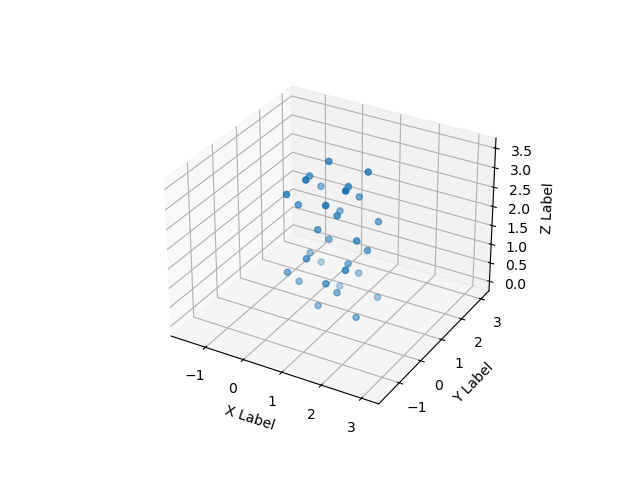

In [49]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

permutation_inv = invert_permutation(permutation)

positions = lattice_x[None,:]*test_sites[:,0][:,None] + lattice_y[None,:] * test_sites[:,1][:,None] + lattice_z[None,:] * test_sites[:,2][:,None] + lattice_s[test_sites[:,3]]

ax.scatter(positions[:,0], positions[:,1], positions[:,2])
"""
ax.plot(positions[permutation,0], positions[permutation,1], positions[permutation,2])

for i in range(test_sites.shape[0]):
    ax.text(positions[i,0], positions[i,1], positions[i,2], str(i), color="blue")


sites = final_sites[f]

x_sites = np.min(sites[:,0])
x_original = np.min(test_sites[:,0])
y_sites = np.min(sites[:,1])
y_original = np.min(test_sites[:,1])
z_sites = np.min(sites[:,2])
z_original = np.min(test_sites[:,2])

sites = sites + np.array([[x_original - x_sites, y_original - y_sites, z_original - z_sites, 0]])

positions = lattice_x[None,:]*sites[:,0][:,None] + lattice_y[None,:] * sites[:,1][:,None] + lattice_z[None,:] * sites[:,2][:,None] + lattice_s[sites[:,3]]

ax.scatter(positions[:,0], positions[:,1], positions[:,2])


for i in range(test_sites.shape[0]):
    ax.text(positions[permutation_inv[i],0], positions[permutation_inv[i],1], positions[permutation_inv[i],2], str(i), color="orange")
"""
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.axis('equal')


In [44]:
permutation

array([ 0,  8, 29, 17, 21, 28,  6, 16,  9,  3, 19,  1, 13, 24, 14, 18, 22,
       26,  2, 30,  4, 23, 10, 31, 27, 20,  5, 15, 11, 12,  7, 25])